# Expression Evaluation (In-Memory)

ironArray has a strong support for expression evaluation.  Things like sums, products, divisions or a pretty complete range of transcendental functions (e.g. `exp`, `sin`, `asin`, `tanh`...).  Fast evaluation of (large) arrays is one of the features that received more love during the development.  Performance comes from a balance between:

1. Use of [Intel MKL](https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html) for accelerating transcendental functions.

2. Use of [Intel SVML](https://software.intel.com/content/www/us/en/develop/documentation/cpp-compiler-developer-guide-and-reference/top/compiler-reference/intrinsics/intrinsics-for-short-vector-math-library-operations/overview-intrinsics-for-short-vector-math-library-svml-functions.html) for computing vector math functions.

3. Use of multi-threading capabilities.

4. Leveraging the 2-level partitioning in ironArray arrays so that most of the computation intensive happens inside private caches (L1, L2), which benefits multi-threading performance.

You can access to the powerful evaluation capabilities in ironArray in different ways, which we are going to succinctly expose in this tutorial.  In order to do that, we are going to make use of the dataset that we created in our reductions tutorial.  Let's go:

In [1]:
%load_ext memprofiler
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import iarray as ia

Now, in order to evaluate some expressions on this, let's put the data for each month on a different array:

In [2]:
%%mprof_run -i 0.1 load
precip1 = ia.load("precip1.iarr")
precip2 = ia.load("precip2.iarr")
precip3 = ia.load("precip3.iarr")

Memory profiler: Used 457.7070 MiB (peak of 393.4414 MiB) in 0.2348 s


Here we can see how the memory is being used during the load process:

In [20]:
%mprof_plot load -t "Memory usage for loading ironArray data"

Note how, even if the data for all the three months takes almost 9 GB uncompressed, ironArray has used just a bit more than 300 MB for holding them in RAM.  This is compression at work.

With that, let's compute something easy, like a new array with the mean of these.  For that, we are going to use the internal evaluation engine:

In [4]:
precip_expr = ia.expr_from_string("(p1 + p2 + p3) / 3", {'p1': precip1, 'p2': precip2, 'p3': precip3})

Ok, that was fast, but we did not quite evaluate anything yet.  In order to do the actual evaluation, we have to call `.eval()` on the expression:

In [5]:
%%mprof_run -i 0.1 ia_mean
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

Memory profiler: Used 435.1133 MiB (peak of 431.3203 MiB) in 0.9304 s


Cool, so we have our first evaluation done.  But let's see how it performs against NumPy, and especially, whether our outcome is correct:

In [6]:
%%mprof_run -i 0.1 _
np_precip1 = precip1.data
np_precip2 = precip2.data
np_precip3 = precip3.data

Memory profiler: Used 8555.9062 MiB (peak of 8587.5156 MiB) in 7.0632 s


Here we see how the data takes around 8 ~ 9 GB of RAM.  Now, let's do the actual mean:

In [7]:
%%mprof_run np_mean
np_precip_mean = (np_precip1 + np_precip2 + np_precip3) / 3

Memory profiler: Used 2852.1484 MiB (peak of 2851.5977 MiB) in 1.5094 s


So, ironArray times are quite competitive with NumPy.  How about the correctness of the outcome?.  Let's see:

In [8]:
%%time
np.testing.assert_almost_equal(np_precip_mean, precip_mean.data)

CPU times: user 10.9 s, sys: 1.57 s, total: 12.5 s
Wall time: 9.64 s


Cool, results are the same. That means that ironArray can run generally faster than NumPy, even if the former uses data in compressed form by default.

Now, let's use expressions with some transcendental functions.  This does not make sense for this case (precipitation data), but we are doing this just as an indication of the efficiency of ironArray:

In [9]:
%%mprof_run ia_trans
result = ia.expr_from_string("(tan(p1) * (sin(p1) * sin(p2) + cos(p2)) + sqrt(p3) * 2)",
                             {'p1': precip1, 'p2': precip2, 'p3': precip3}
                             ).eval()
result

<IArray (720, 721, 1440) np.float32>

Memory profiler: Used 614.0742 MiB (peak of 625.7383 MiB) in 1.4146 s


In this case we see that the overhead of using transcendental functions is pretty low compared with plain arithmetic operations (sum, rest, mult, division...). Let's compare this against NumPy:

In [10]:
%%mprof_run np_trans
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_result = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

Memory profiler: Used 2851.7070 MiB (peak of 8554.7383 MiB) in 7.9935 s


Ok, this is really slow, but this is kind of expected, as ironArray comes with support for evaluating transcendental functions via MKL, while NumPy does not.

But do not forget to check for correctness:

In [11]:
%%time
np.testing.assert_almost_equal(np_result, result.data)

CPU times: user 11.9 s, sys: 1.56 s, total: 13.5 s
Wall time: 9.54 s


So not a noticeable difference, as expected.

## Lazy expressions

So far we have been using strings as the way to build expressions.  However, there is a handier (and perhaps more elegant) way to build expressions via the so-called lazy expressions.  With lazy expressions you just express your computations in terms of `IArray` objects.

For example, the mean of the precipitation would be expressed as:

In [12]:
%%mprof_run _
precip_expr = (precip1 + precip2 + precip3) / 3
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

Memory profiler: Used 426.1992 MiB (peak of 437.3750 MiB) in 0.9803 s


Lazy expressions are similar to how you use NumPy to evaluate expressions with some differences:

1. You need to be explicit when you want to `.eval()`-uate the expressions.

2. There are no big temporaries involved.  The expression is compiled on the flight and large temporaries are avoided.  This means not only that we require less memory, but more importantly, that expressions evaluate faster (memory access is always expensive).

For evaluating expressions with transcendental functions you need to use ironArray methods:

In [13]:
%%mprof_run _
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2
# Yoy can also use the next idiom, which is not as close to NumPy, but a hair more concise
#lazy_expr = precip1.tan() * (precip1.sin() * precip2.sin() + precip2.cos()) + precip3.sqrt() * 2
lazy_result = lazy_expr.eval()
lazy_result

<IArray (720, 721, 1440) np.float32>

Memory profiler: Used 582.5625 MiB (peak of 591.8594 MiB) in 1.3950 s


Note how execution times and memory usage are very similar to the string expressions evaluator.

As you can see, lazy expressions allow for a more Pythonic way to integrate ironArray operands in expressions, just like NumPy (only more memory efficient and faster).  In general, you can use the method you like the most, although evaluation of string expressions tends to be a hair faster, especially when using small arrays.

As always, let's check that the result is correct:

In [14]:
%%time
np.testing.assert_almost_equal(np_result, lazy_result.data)

CPU times: user 11.9 s, sys: 1.6 s, total: 13.5 s
Wall time: 9.58 s


## Resource consumption

(Update this when memprof would support accessing to measurements)
As a summary, let's do a plot on the speed for the different kind of computations:

In [21]:
%mprof_plot ia_mean np_mean -t "Mean computation"

As we can see iron_array not only makes computations faster, but specially requiring much less memory.

In [23]:
%mprof_plot ia_trans np_trans -t "Transcendental expression"

And the same goes for the transcendental expression.

### In-deep memory consumption analysis

Memory efficiency is critical for ironArray, so let's dig a bit more on the pattern of the memory used for both types of computations.  Let's start with ironArray:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


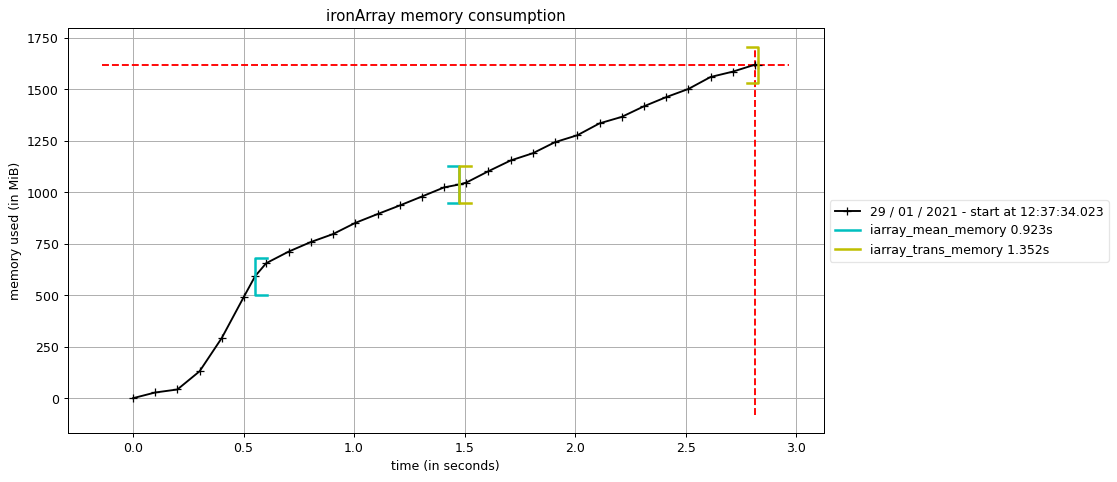

In [17]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

The first part of the plot is the loading process of the 3 months of precipitation arrays from disk.  This process stops when the 600 MB mark is reached, meaning that the (compressed) data takes that storage in memory.  The part between blue brackets corresponds to the actual mean computation and ~500 MB were needed to host the mean array.  Finally, the yellow brackets show the computation of the transcendental expression (around 700 MB more).  In the end, ironArray has needed a grand total of 1.6 GB so as to evaluate the *two* expresions.

Now, let's see what is the memory consumption for NumPy:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


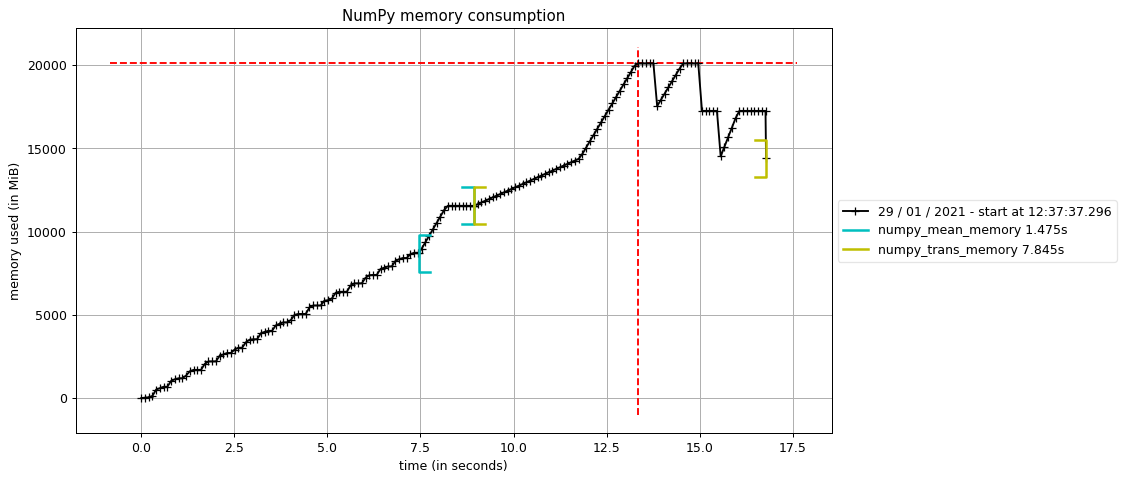

In [18]:
%rm numpy_mean_memory.dat
%run -m mprof run -o numpy_mean_memory.dat numpy_mean_memory.py
%run -m mprof plot numpy_mean_memory.dat -t "NumPy memory consumption"

In this case, the first part of the plot stops around 8.5 GB (the size of the uncompressed dataset).  The section between blue brackets is where the mean is computed.  In this case, NumPy is well optimized, as it does not seem to use big temporaries (and this is part of the reason on why its computation speed is pretty good).  However, the section for the transcendental evaluation (yellow brackets) shows a more complex pattern, with 2 peaks before reaching the end of the computation.  These peaks clearly correspond to the big temporaries that are needed during the evaluation.  In the end, NumPy has needed around 20 GB so as to evaluate the two expressions.  In comparison, ironArray consumes more than 10x less memory for the same task.

In general, this means that ironArray can perform operations requiring less memory than using non-compressed arrays, while using a similar time (or much less, like e.g. expressions requiring large temporaries or intermediate function evaluation).

Finally, when we want to minimize the amount of memory during computations, ironArray can also perform evaluations on arrays that are resident on disk (aka out-of-core) in a completely transparent way.  This is the subject of the 'on-disk' counterpart of this tutorial.